# Предсказание вероятности клика по рекламному объявлению

**Краткое описание**

Требуется получить на выходе прогноз с высокой точностью вероятности клика по рекламному объявлению.
<br>На предикт ML модели выдается выборка объявлений доступных в текущий момент к показу, модель выдает по ним вероятность клика.

**Задача**

- Выбор модели для получения предсказаний.
- Обосновавние выбора

**План выполнения**
- Знакомство с данными
- Исследовательский анализ данных
- Предобработка данных
- Разработка дополнительных признаков (при необходимости)
- Построение baseline
- Обучение нескольких моделей
- Выбор лучшей модели
- Проверка важности признаков
- Проверка лучшей модели на отложенной выборке
- Заключение о проделанном исследовании

**Описание данных**
- `region_id` - id региона показа
- `city_id` - id города
- `tags_cont` - значение контекстного таргетинга
- `tags_bhv` - значение таргетинга по поведению
- `rubrica` - тематика объявления
- `rate` - ставка в рублях объявления
- `ctr_sort` - значение ctr объявления
- `rv_perc` - процент видимости объявления
- `slider` - тип рекламного блока
- `position_type` - значение позиции рекламного блока на странице сайта

**Метрики для оценки качества модели**
- основная метрика - `ROC AUC`
- дополнительная - `F1`

## Установка зависимостей

In [8]:
# !pip install pandas
# !pip install seaborn
# !pip install phik
# !pip install category_encoders
# !pip install python-dotenv
# !pip install mlflow
# !pip install psycopg2-binary
# !pip install autofeat
# !pip install optuna
# !pip install lightgbm
!pip freeze > requirements.txt

In [16]:
# Импорт стандартных библиотек
import os

# Импорт библиотек для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Импорт библиотек для работы с данными
import pandas as pd
import numpy as np

# Импорт дополнительных библиотек
import joblib
import mlflow
from phik.report import plot_correlation_matrix

# Импорт пользовательских функций
from research_functions import (
    data_review,
    data_preprocessing,
    model_fitting,
    model_logging,
    models_comparison,
    test_best_model
    )

In [2]:
# Автоматическая перезагрузка модулей
%load_ext autoreload
%autoreload 2

# Импорт модуля research_functions
import research_functions

Объявление глобальных переменных

In [3]:
DATA_DIR = 'data'
ASSETS_DIR = 'assets'
RANDOM_STATE = 42
TEST_SIZE = 0.1

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64
pd.options.mode.copy_on_write = True

sns.set_theme(style='white', palette='husl')

%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

## Знакомство с данными

In [4]:
data = pd.read_csv(os.path.join(DATA_DIR, 'dataset.csv'))
data_y23 = pd.read_csv(os.path.join(DATA_DIR, 'dataset_2023_10_30.csv'))

### dataset

In [5]:
data_review(data)

Общая информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803526 entries, 0 to 803525
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   region_id      803526 non-null  int64  
 1   city_id        803526 non-null  int64  
 2   tags_cont      803526 non-null  float64
 3   tags_bhv       803526 non-null  float64
 4   rubrica        803526 non-null  float64
 5   rate           803526 non-null  float64
 6   ctr_sort       803526 non-null  float64
 7   rv_perc        803526 non-null  float64
 8   slider         803526 non-null  int64  
 9   position_type  803526 non-null  int64  
 10  target         803526 non-null  int64  
dtypes: float64(6), int64(5)
memory usage: 67.4 MB

Первые пять строк набора данных:


,region_id,city_id,tags_cont,tags_bhv,rubrica,rate,ctr_sort,rv_perc,slider,position_type,target
0,38,590,0.0,0.500,1.812,1.7,1.3072,66.41,1,0,1
1,53,577,0.0,0.000,0.000,4.8,0.6568,46.79,1,0,1
2,48,0,0.0,0.000,1.950,1.7,1.3072,66.41,1,0,1
3,20,596,0.0,1.103,0.000,1.7,1.3072,94.44,0,0,1
4,290,0,0.0,0.750,0.000,1.0,1.1369,77.69,0,0,1



количество полных дубликатов строк: 255574

количество пропущенных значений: 
    region_id        0
city_id          0
tags_cont        0
tags_bhv         0
rubrica          0
rate             0
ctr_sort         0
rv_perc          0
slider           0
position_type    0
target           0
dtype: int64

Вывод количества уникальных записей в каждом числовом признаке:
Количество уникальных записей в признаке 'region_id': 228
Количество уникальных записей в признаке 'city_id': 174
Количество уникальных записей в признаке 'tags_cont': 1527
Количество уникальных записей в признаке 'tags_bhv': 4687
Количество уникальных записей в признаке 'rubrica': 3153
Количество уникальных записей в признаке 'rate': 64
Количество уникальных записей в признаке 'ctr_sort': 3085
Количество уникальных записей в признаке 'rv_perc': 5238
Количество уникальных записей в признаке 'slider': 2
Количество уникальных записей в признаке 'position_type': 26
Количество уникальных записей в признаке 'target': 2


### dataset_23

In [6]:
data_review(data_y23)

Общая информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648184 entries, 0 to 648183
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   region_id      648184 non-null  int64  
 1   city_id        648184 non-null  int64  
 2   tags_cont      648184 non-null  float64
 3   tags_bhv       648184 non-null  float64
 4   rubrica        648184 non-null  float64
 5   rate           648184 non-null  float64
 6   ctr_sort       648184 non-null  float64
 7   rv_perc        648184 non-null  float64
 8   slider         648184 non-null  int64  
 9   position_type  648184 non-null  int64  
 10  target         648184 non-null  int64  
dtypes: float64(6), int64(5)
memory usage: 54.4 MB

Первые пять строк набора данных:


,region_id,city_id,tags_cont,tags_bhv,rubrica,rate,ctr_sort,rv_perc,slider,position_type,target
0,38,617,0.0,0.000,0.000,26.25,0.6608,89.97,0,0,1
1,284,0,0.0,0.000,1.750,1.50,1.8803,27.31,0,0,1
2,157,0,0.0,2.576,1.488,0.70,1.3899,78.42,1,0,1
3,228,0,0.0,0.000,0.000,0.75,1.6981,7.75,0,21,1
4,51,579,0.0,0.000,0.000,1.60,1.3530,77.69,0,0,1



количество полных дубликатов строк: 205732

количество пропущенных значений: 
    region_id        0
city_id          0
tags_cont        0
tags_bhv         0
rubrica          0
rate             0
ctr_sort         0
rv_perc          0
slider           0
position_type    0
target           0
dtype: int64

Вывод количества уникальных записей в каждом числовом признаке:
Количество уникальных записей в признаке 'region_id': 226
Количество уникальных записей в признаке 'city_id': 183
Количество уникальных записей в признаке 'tags_cont': 7054
Количество уникальных записей в признаке 'tags_bhv': 8622
Количество уникальных записей в признаке 'rubrica': 2732
Количество уникальных записей в признаке 'rate': 76
Количество уникальных записей в признаке 'ctr_sort': 3364
Количество уникальных записей в признаке 'rv_perc': 5673
Количество уникальных записей в признаке 'slider': 2
Количество уникальных записей в признаке 'position_type': 24
Количество уникальных записей в признаке 'target': 2


### Выводы
- оба набора данных представлены исключительно числовыми данными;
- в обоих наборах примерно 30% строк являются повторами;
- в наборах отсутствуют идентификаторы рекламных объявлений;
- ввиду схожести наборов и отсутствия идентификаторов принимаю решение их объединить

### common_df

In [7]:
df = pd.concat([data, data_y23], axis=0, ignore_index=True)

In [8]:
data_review(df)

Общая информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1451710 entries, 0 to 1451709
Data columns (total 11 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   region_id      1451710 non-null  int64  
 1   city_id        1451710 non-null  int64  
 2   tags_cont      1451710 non-null  float64
 3   tags_bhv       1451710 non-null  float64
 4   rubrica        1451710 non-null  float64
 5   rate           1451710 non-null  float64
 6   ctr_sort       1451710 non-null  float64
 7   rv_perc        1451710 non-null  float64
 8   slider         1451710 non-null  int64  
 9   position_type  1451710 non-null  int64  
 10  target         1451710 non-null  int64  
dtypes: float64(6), int64(5)
memory usage: 121.8 MB

Первые пять строк набора данных:


,region_id,city_id,tags_cont,tags_bhv,rubrica,rate,ctr_sort,rv_perc,slider,position_type,target
0,38,590,0.0,0.500,1.812,1.7,1.3072,66.41,1,0,1
1,53,577,0.0,0.000,0.000,4.8,0.6568,46.79,1,0,1
2,48,0,0.0,0.000,1.950,1.7,1.3072,66.41,1,0,1
3,20,596,0.0,1.103,0.000,1.7,1.3072,94.44,0,0,1
4,290,0,0.0,0.750,0.000,1.0,1.1369,77.69,0,0,1



количество полных дубликатов строк: 461322

количество пропущенных значений: 
    region_id        0
city_id          0
tags_cont        0
tags_bhv         0
rubrica          0
rate             0
ctr_sort         0
rv_perc          0
slider           0
position_type    0
target           0
dtype: int64

Вывод количества уникальных записей в каждом числовом признаке:
Количество уникальных записей в признаке 'region_id': 245
Количество уникальных записей в признаке 'city_id': 183
Количество уникальных записей в признаке 'tags_cont': 7301
Количество уникальных записей в признаке 'tags_bhv': 8813
Количество уникальных записей в признаке 'rubrica': 3843
Количество уникальных записей в признаке 'rate': 95
Количество уникальных записей в признаке 'ctr_sort': 5584
Количество уникальных записей в признаке 'rv_perc': 7679
Количество уникальных записей в признаке 'slider': 2
Количество уникальных записей в признаке 'position_type': 26
Количество уникальных записей в признаке 'target': 2


## Исследовательский анализ данных

In [9]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
print('произведено удаление дубликатов строк')

произведено удаление дубликатов строк


2024-06-14 17:04:24,350 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-14 17:04:24,364 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-14 17:04:24,772 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-14 17:04:24,782 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-14 17:04:24,876 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates

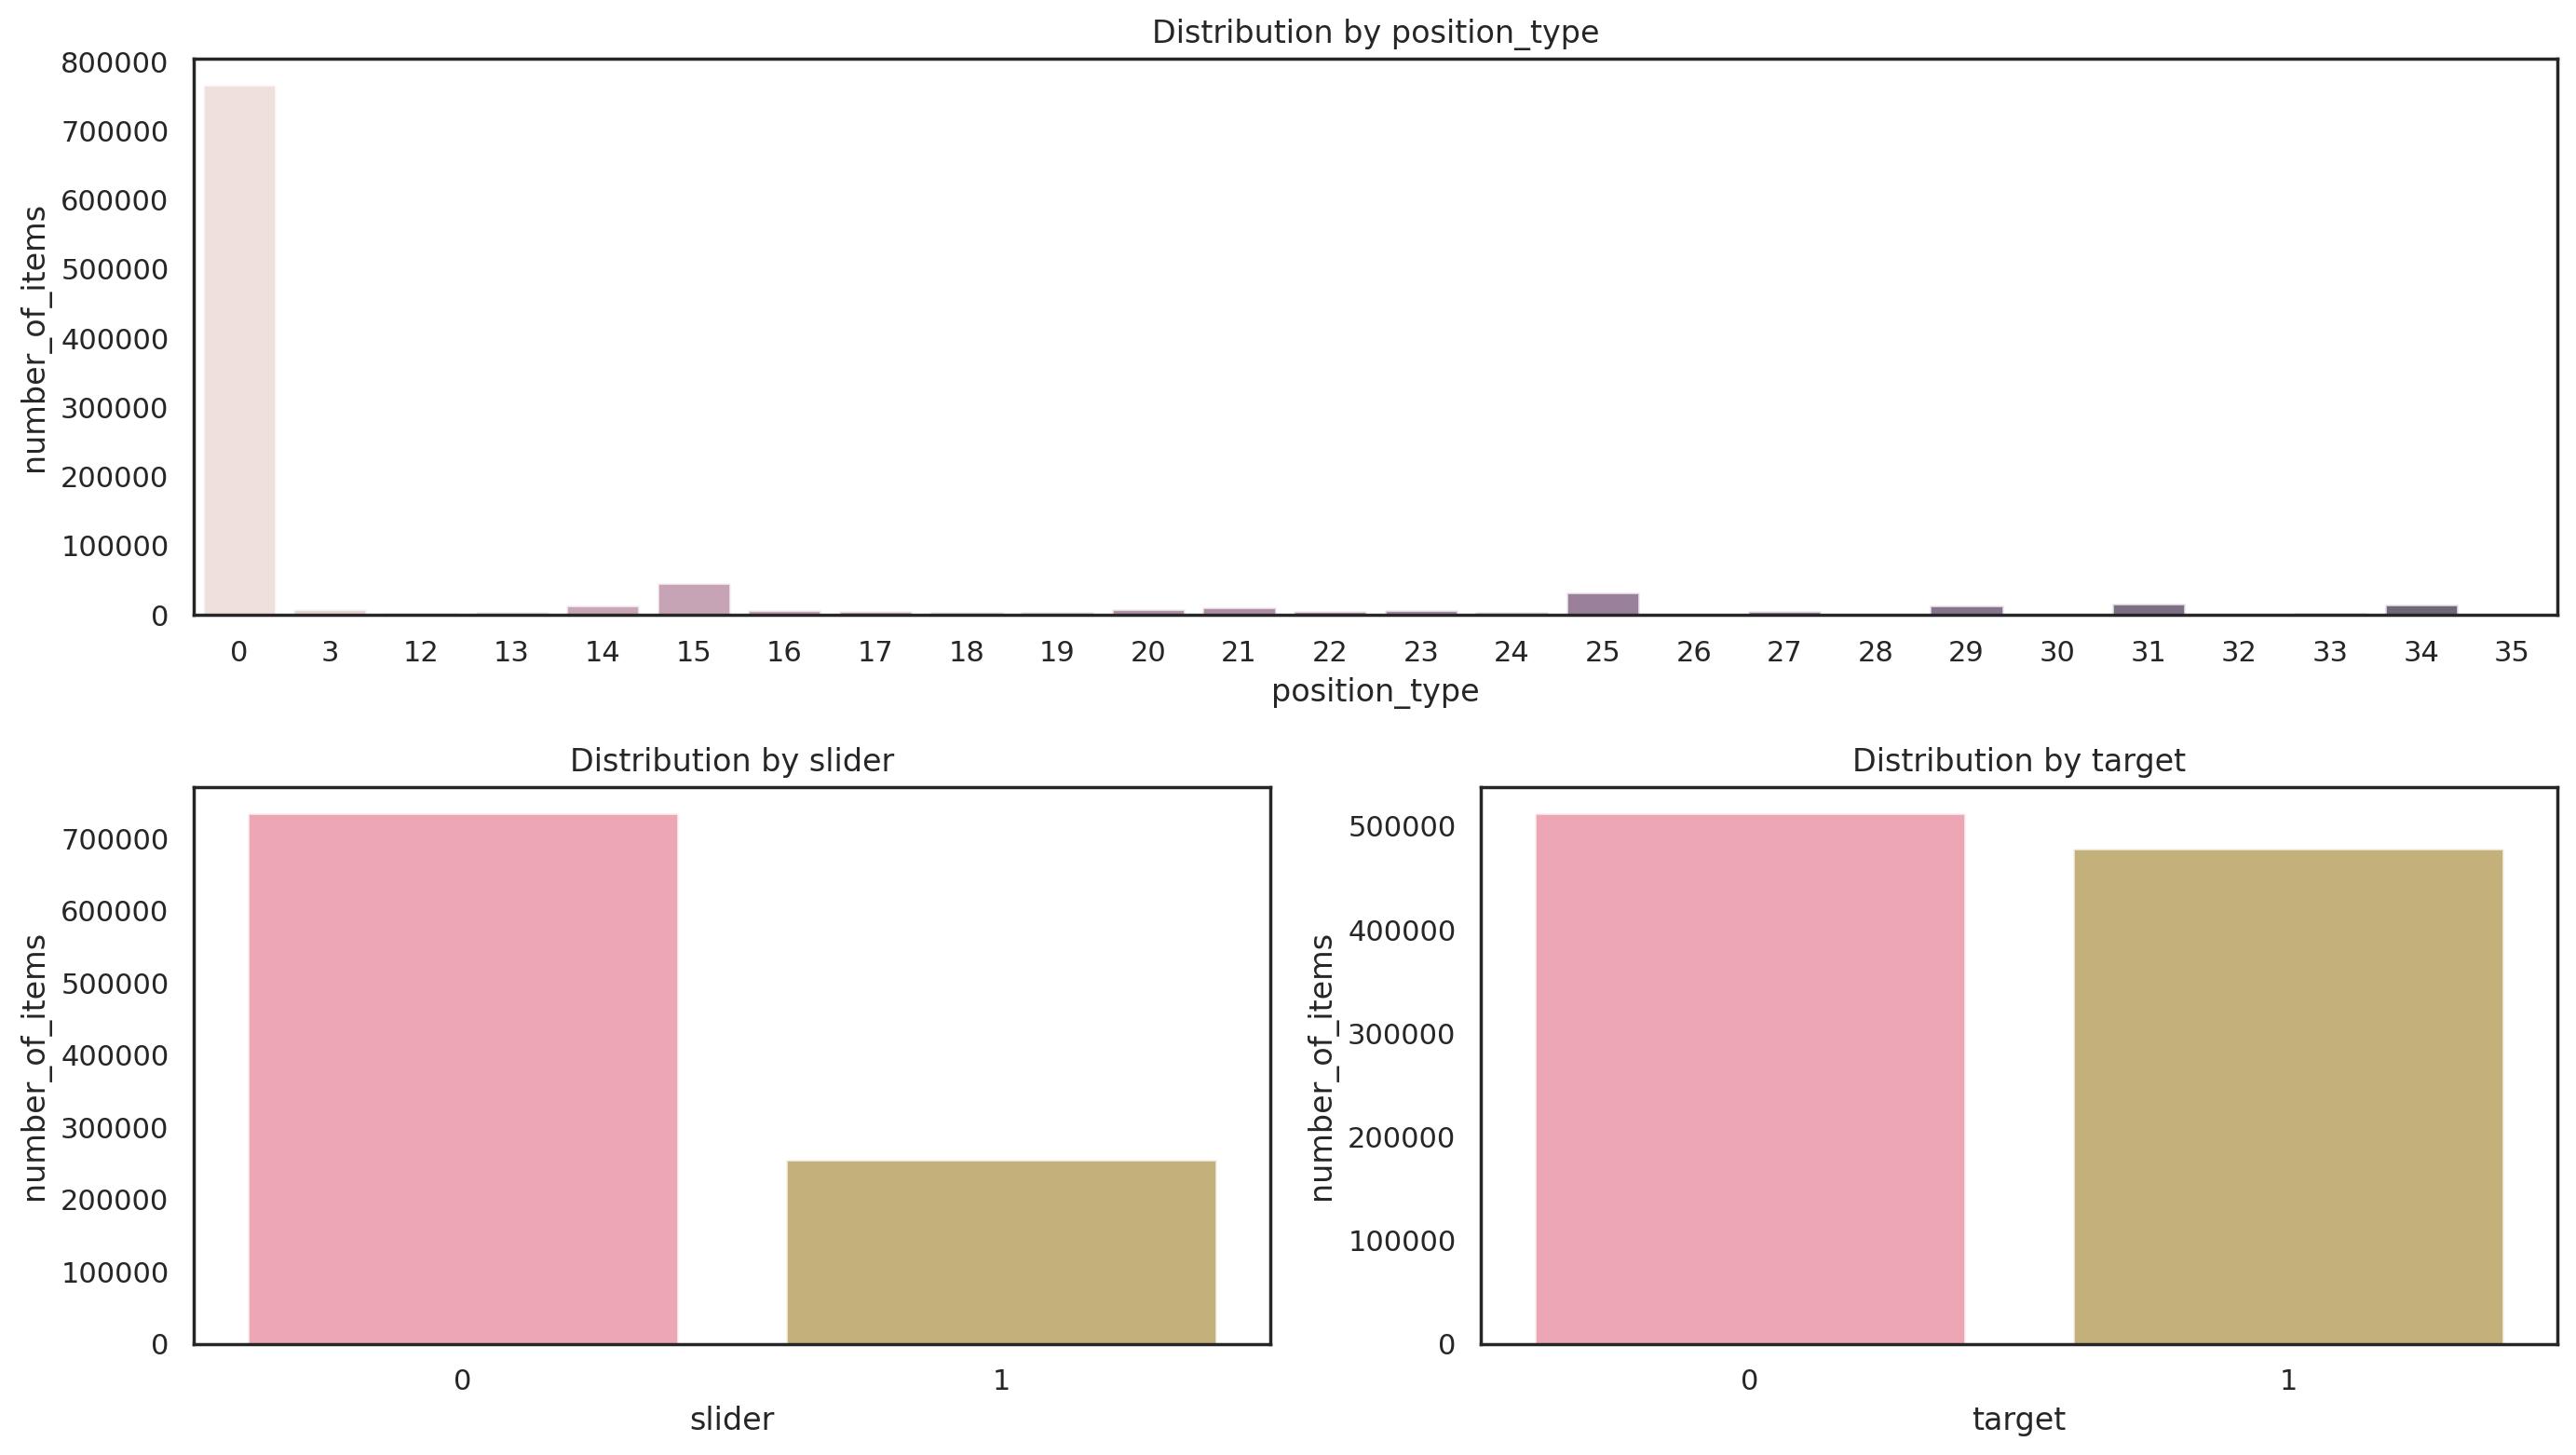

In [10]:
def plot_distribution(ax, data, title):
    sns.barplot(x=data.index,
                y=data.values,
                hue=data.index,
                ax=ax,
                alpha=0.7,
                legend=False)
    ax.set_ylabel('number_of_items')
    ax.set_title(title)

fig = plt.figure(figsize=(14, 8))
gs = GridSpec(2, 2, figure=fig)

titles = ['Distribution by position_type', 'Distribution by slider', 'Distribution by target']
data_columns = ['position_type', 'slider', 'target']

for i, (title, column) in enumerate(zip(titles, data_columns)):
    ax = fig.add_subplot(gs[i, :]) if i == 0 else fig.add_subplot(gs[1, i-1])
    plot_distribution(ax, df[column].value_counts(), title)

plt.savefig(os.path.join(ASSETS_DIR, 'Distribution by categories in the position_type, slider, target.png'))
plt.tight_layout()
plt.show()

In [11]:
print('Описательные статистики данных:')
df.describe()

Описательные статистики данных:


,region_id,city_id,tags_cont,tags_bhv,rubrica,rate,ctr_sort,rv_perc,slider,position_type,target
count,990388.000000,990388.000000,990388.000000,990388.000000,990388.000000,990388.000000,990388.000000,990388.000000,990388.000000,990388.000000,990388.000000
mean,97.477767,288.691119,0.668996,0.553418,0.785536,3.213062,1.033218,36.203667,0.258030,4.832856,0.482866
std,94.721202,309.637499,1.942030,1.341036,1.386387,4.409356,0.456534,28.678911,0.437551,9.619059,0.499707
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.000000,0.000000,0.000000,0.000000,0.000000,1.260000,0.678500,11.840000,0.000000,0.000000,0.000000
50%,65.000000,0.000000,0.000000,0.000000,0.000000,1.700000,1.072700,28.610000,0.000000,0.000000,0.000000
75%,141.000000,592.000000,0.000000,0.625000,1.500000,2.000000,1.304500,58.950000,1.000000,0.000000,1.000000
max,500.000000,767.000000,10.000000,70.629000,13.094000,45.000000,6.931800,100.000000,1.000000,35.000000,1.000000


### Анализ целевой переменной в зависимости от различных признаков

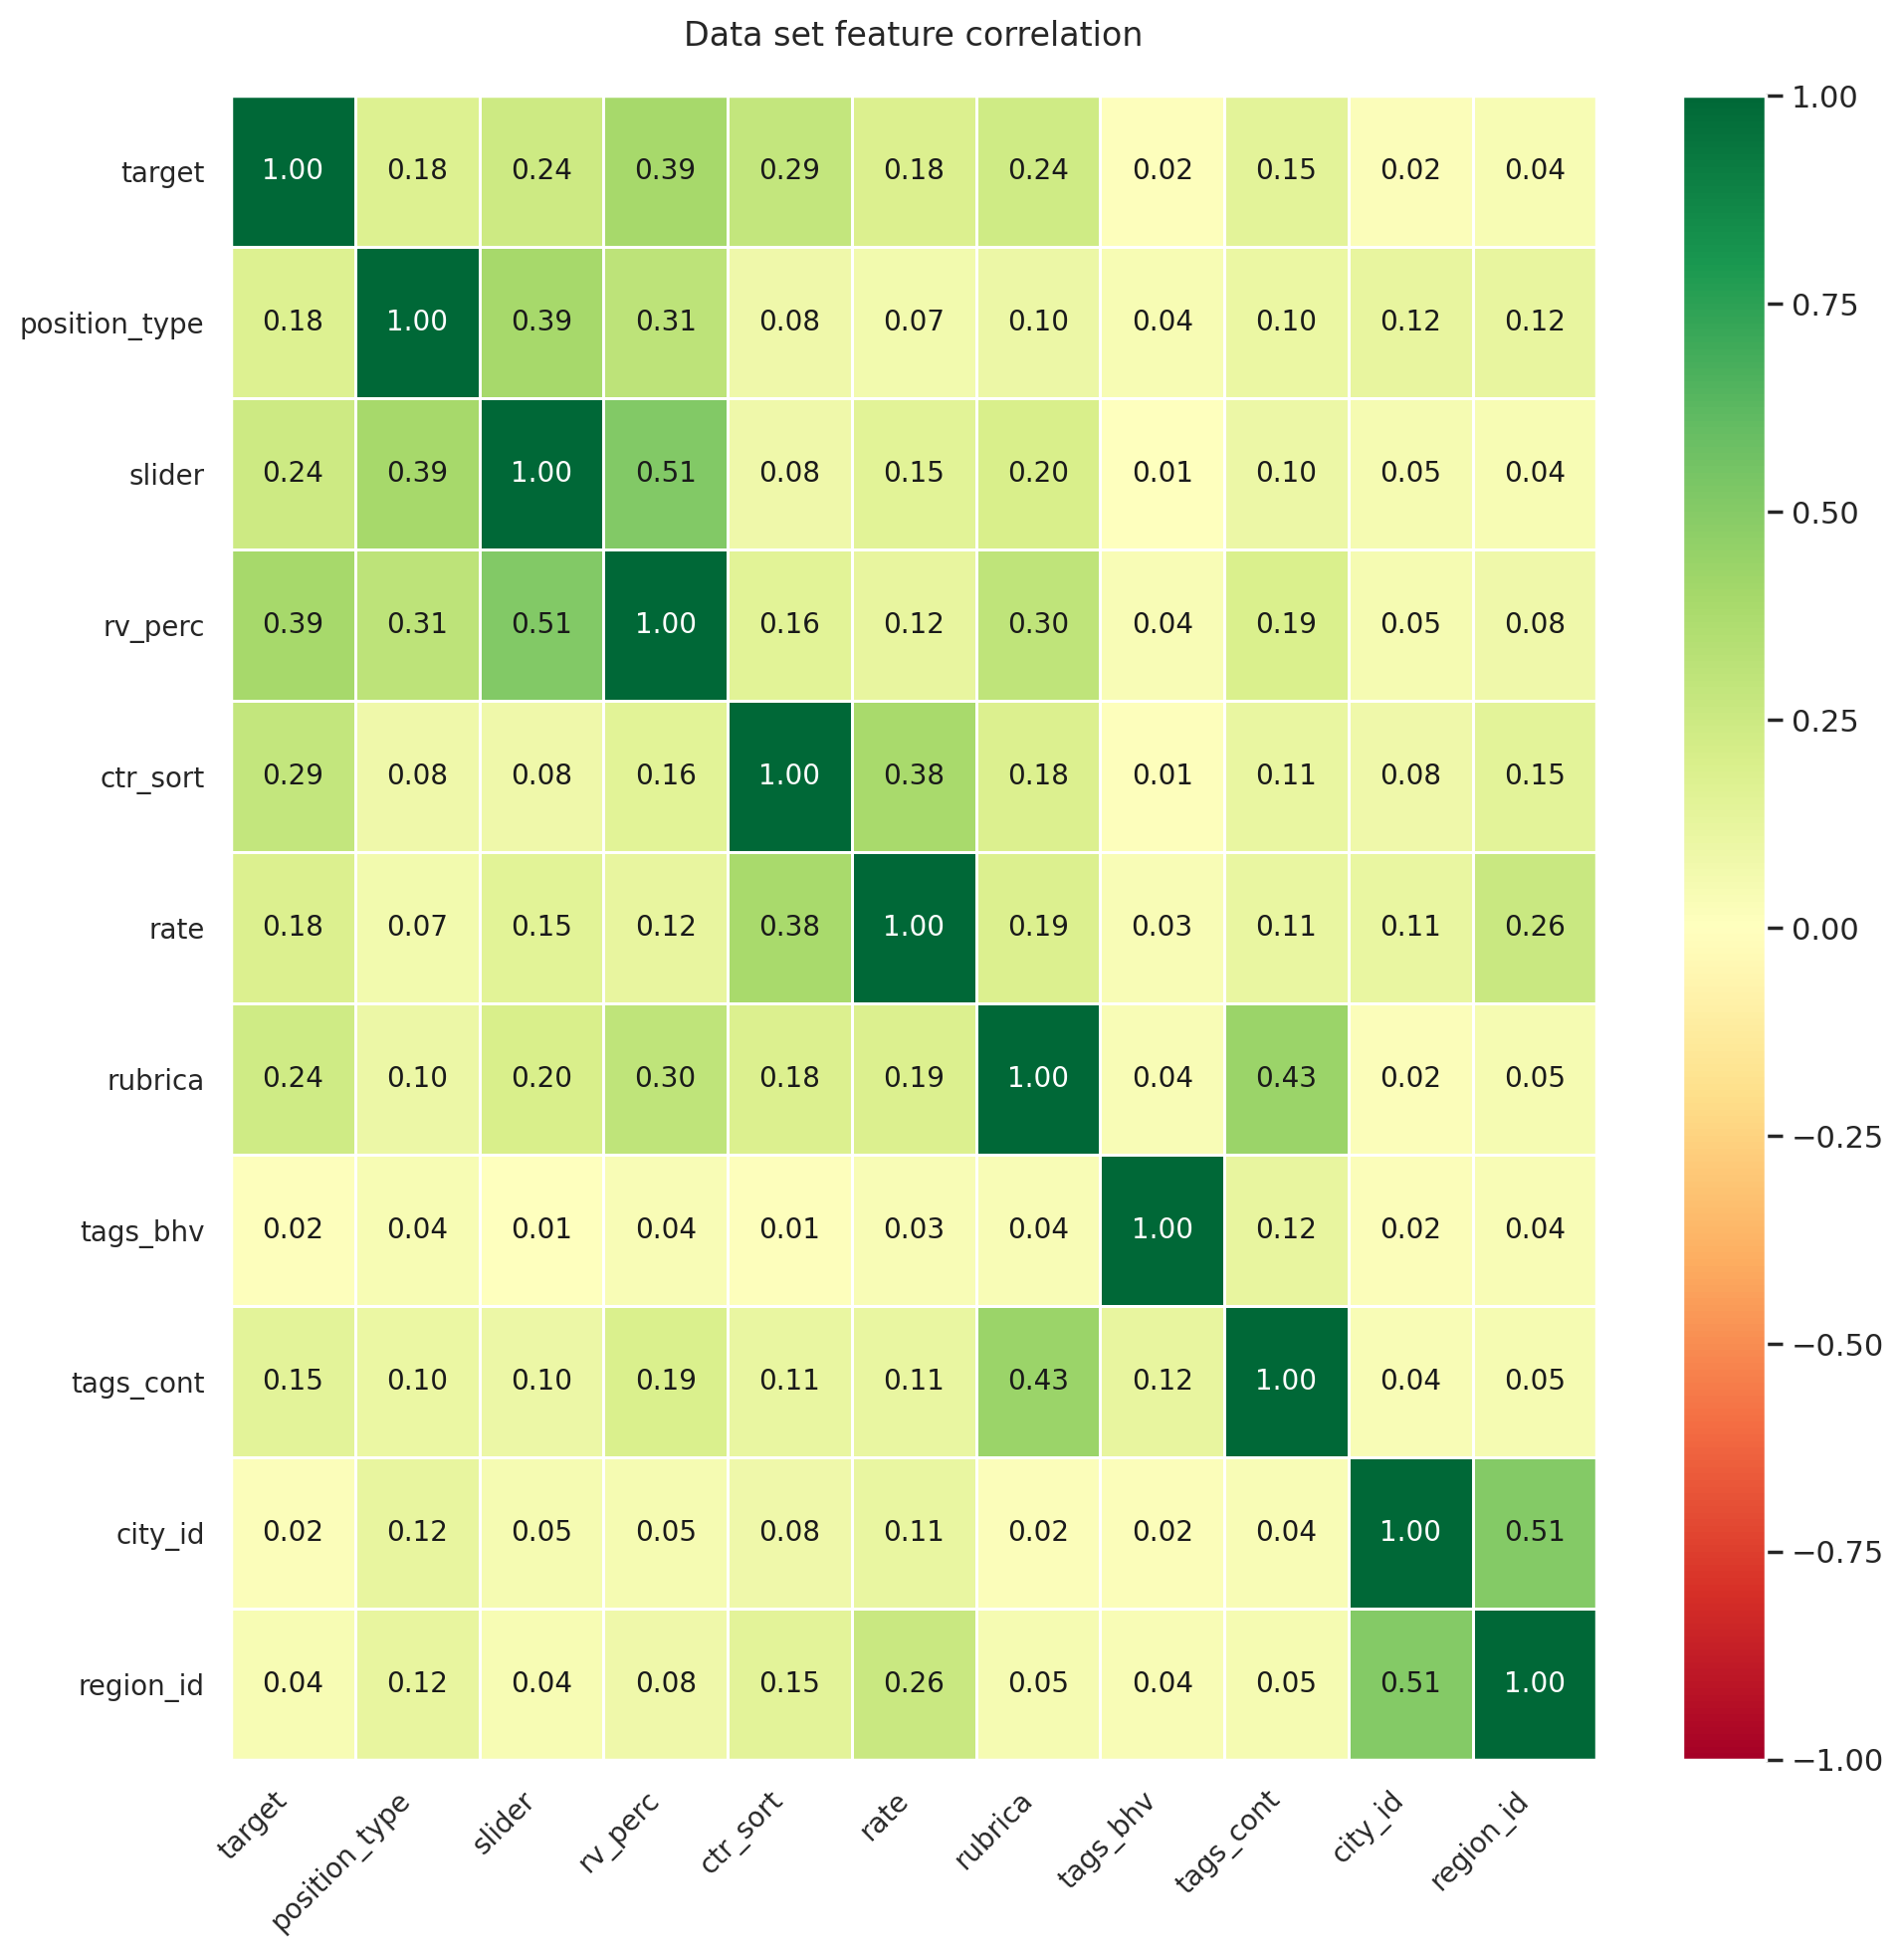

In [12]:
phik_overview = df.phik_matrix(interval_cols=df.columns.to_list())
sns.set()
plot_correlation_matrix(phik_overview.values,
						x_labels=phik_overview.columns,
						y_labels=phik_overview.index,
						fontsize_factor=1.0,
						figsize=(10, 10))
plt.xticks(rotation=45, ha='right')
plt.title(f'Data set feature correlation', fontsize=12, y=1.02)
plt.savefig(os.path.join(ASSETS_DIR, 'Dataset feature correlation.png'))
plt.tight_layout()

Сохранение датафрейма

In [4]:
# df.to_csv(os.path.join(DATA_DIR, 'clean_df.csv'))
df = pd.read_csv(os.path.join(DATA_DIR, 'clean_df.csv'), index_col='Unnamed: 0')

### Выводы
- в целевой переменной наблюдается незначительный дисбаланс классов;
- большой дисбаланс прослеживается в признаках `slider` и `position_type`;
- в признаке `position_type` почти все данные относятся к значению 0,
  <br>что делает данный признак малоинформативным кандидатом на исключение;
- по описательным статистикам критичных аномалий не выявлено;
- изучение корреляций не выявило сильных скрытых зависимостей признаков с целевой переменной;
- между некоторыми признаками имеются небольшие логически объяснимые зависимости.

## Предобработка данных

In [14]:
X_train_bl, X_test_bl, y_train, y_test = data_preprocessing(test_size=TEST_SIZE,
                                                            dataset=df,
                                                            features=df.drop(['position_type', 'target'], axis=1).columns.tolist(),
                                                            target='target',
                                                            transformations=None)

размерности выборок: ((891349, 9), (99039, 9), (891349,), (99039,))


## Построение baseline

результаты кросс-вадидации: {'fit_time': 3.077, 'score_time': 0.613, 'test_roc_auc': 0.734, 'test_f1_micro': 0.669, 'test_f1': 0.652, 'test_f1_weighted': 0.669, 'test_f1_macro': 0.668}


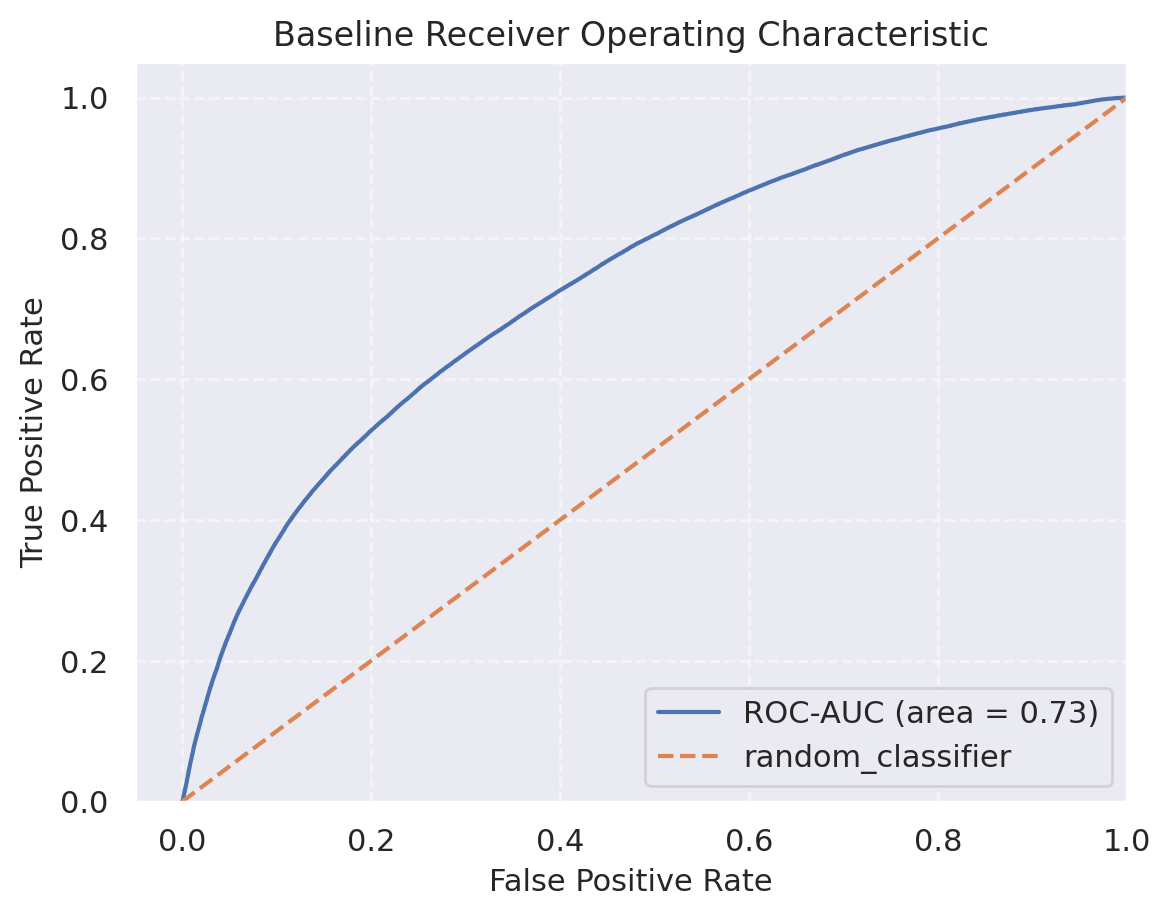

In [15]:
baseline_params = {'class_weight': 'balanced',
                   'C': 1.0,
                   'penalty': 'l2',
                   'max_iter': 1000,
                   'random_state': RANDOM_STATE}
f1_bl, roc_auc_bl, baseline = model_fitting(model_name='Baseline',
                                            features_train=X_train_bl,
                                            target_train=y_train,
                                            n_splits=round(X_train_bl.shape[0]/X_test_bl.shape[0]),
                                            params=baseline_params)

Логирование результатов

In [14]:
signature = mlflow.models.infer_signature(X_train_bl, y_train)
input_example = X_train_bl[:10]
metadata = {
    "author": "denis_zeit",
    "training_date": "2024-06-14",
    "data_used": 'clean_common_df',
    "library_versions": {"mlflow": "2.11.3",
                         "scikit-learn":"1.5.0"}
}
metrics_bl = {'f1_score': f1_bl, 'roc_auc_score': roc_auc_bl}

/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [87]:
model_logging(signature=signature,
              input_example=input_example,
              metadata=metadata,
              metrics=metrics_bl,
              model=baseline,
              params=baseline_params,
              run_name='baseline_0_registry',
              reg_model_name='baseline_scope')

Successfully registered model 'baseline_scope'.
2024/06/14 11:03:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: baseline_scope, version 1
Created version '1' of model 'baseline_scope'.


Визуализация залогированных данных

Models and their metrics:


,experiment_name,run_name,model_name,model_version,f1_score,roc_auc_score
0,click_pred,baseline_0_registry,baseline_scope,1,0.652,0.734


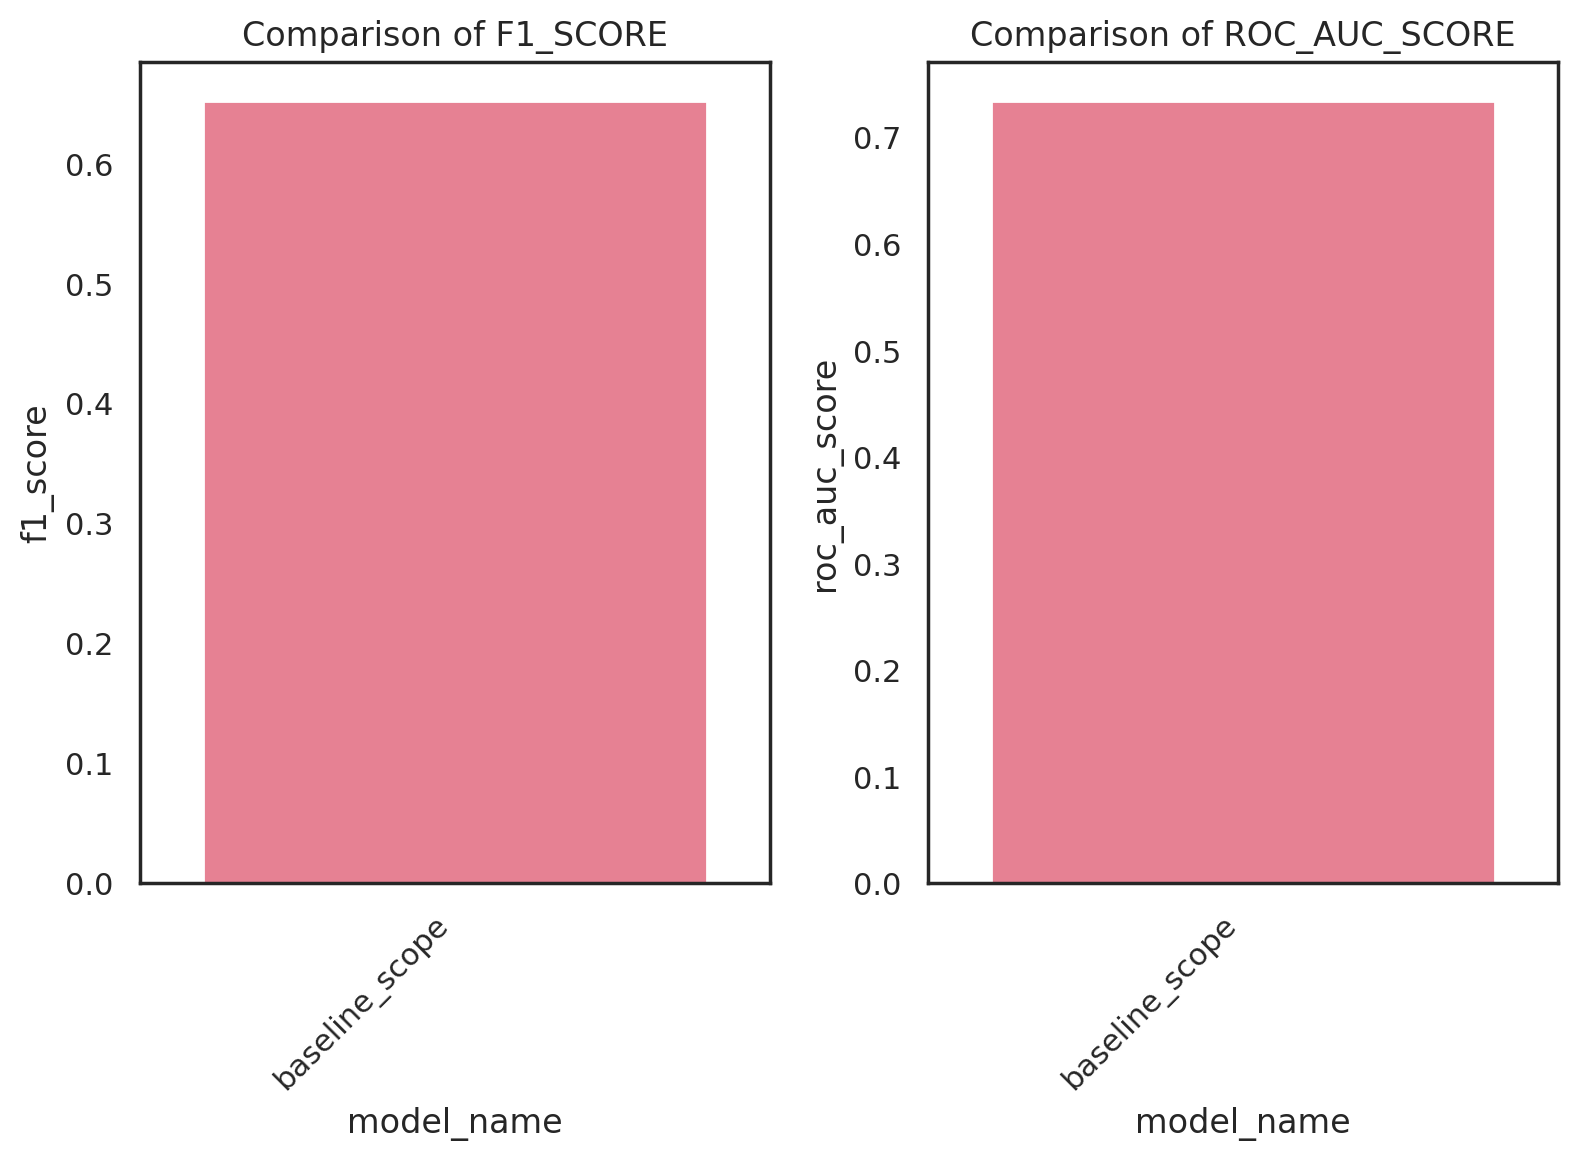

In [6]:
models_comparison(save_figure=False)

### Вывод
- в качестве baseline принята модель логистической регрессии с гиперпараметрами по умолчанию;
- получены базовые метрики: `ROC AUC = 0.734`, `F1 = 0.652`

## Обучение моделей

### Случайный лес

результаты кросс-вадидации: {'fit_time': 110.026, 'score_time': 1.793, 'test_roc_auc': 0.748, 'test_f1_micro': 0.679, 'test_f1': 0.652, 'test_f1_weighted': 0.678, 'test_f1_macro': 0.677}


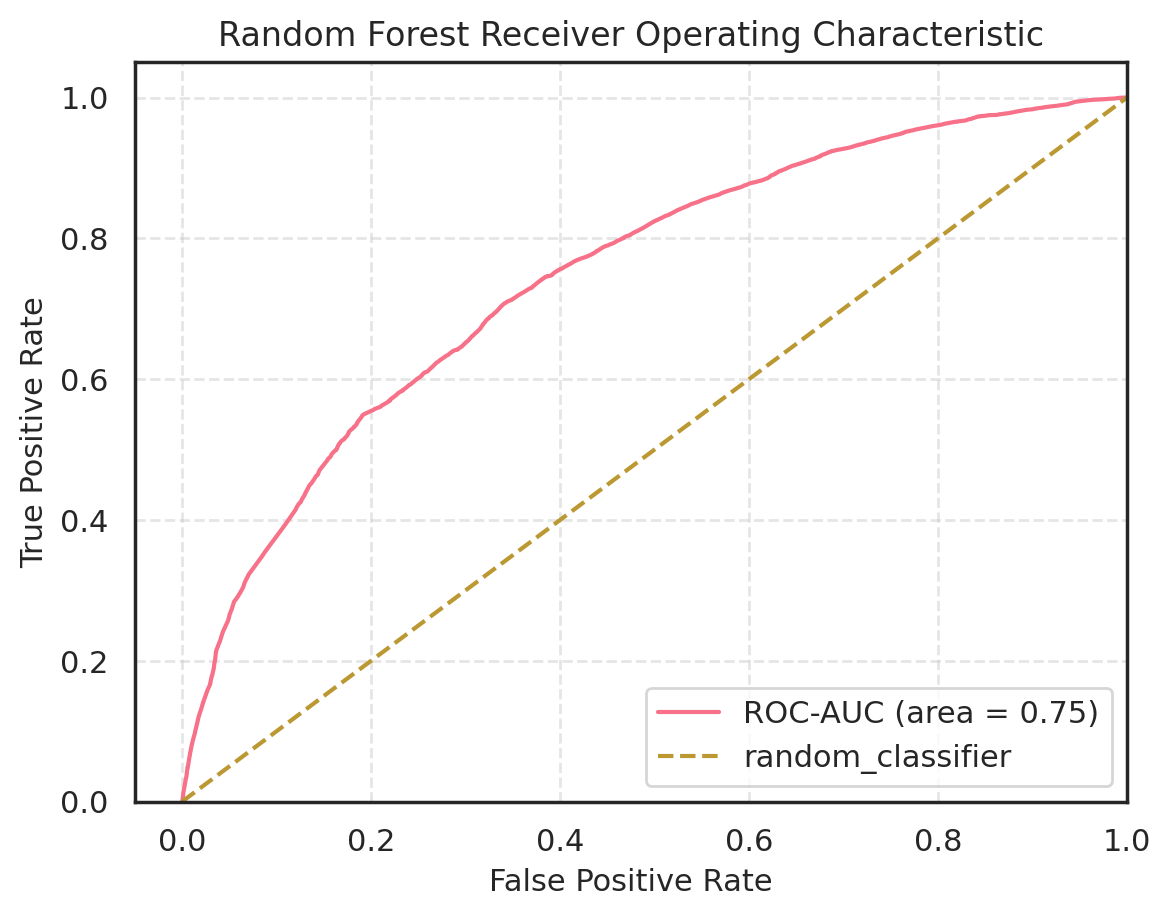

In [6]:
rf_params = {'n_estimators': 100,
             'criterion': 'gini',
             'max_depth': 3,
             'class_weight': 'balanced',
             'random_state': RANDOM_STATE,
             'n_jobs': -1}
f1_rf, roc_auc_rf, base_rf = model_fitting(model_name='Random Forest',
                                           features_train=X_train_bl,
                                           target_train=y_train,
                                           n_splits=round(X_train_bl.shape[0]/X_test_bl.shape[0]),
                                           params=rf_params)

In [7]:
signature = mlflow.models.infer_signature(X_train_bl, y_train)
input_example = X_train_bl[:10]
metadata = {
    "author": "denis_zeit",
    "training_date": "2024-06-14",
    "data_used": 'clean_common_df',
    "library_versions": {"mlflow": "2.11.3",
                         "scikit-learn":"1.5.0"}
}
metrics_rf = {'f1_score': f1_rf, 'roc_auc_score': roc_auc_rf}

model_logging(signature=signature,
              input_example=input_example,
              metadata=metadata,
              metrics=metrics_rf,
              model=base_rf,
              params=rf_params,
              run_name='base_rf_registry',
              reg_model_name='base_rf_scope')

/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'base_rf_scope'.
2024/06/14 12:20:37 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: base_rf_sco

Models and their metrics:


,experiment_name,run_name,model_name,model_version,f1_score,roc_auc_score
0,click_pred,baseline_0_registry,baseline_scope,1,0.652,0.734
1,click_pred,base_rf_registry,base_rf_scope,1,0.652,0.748


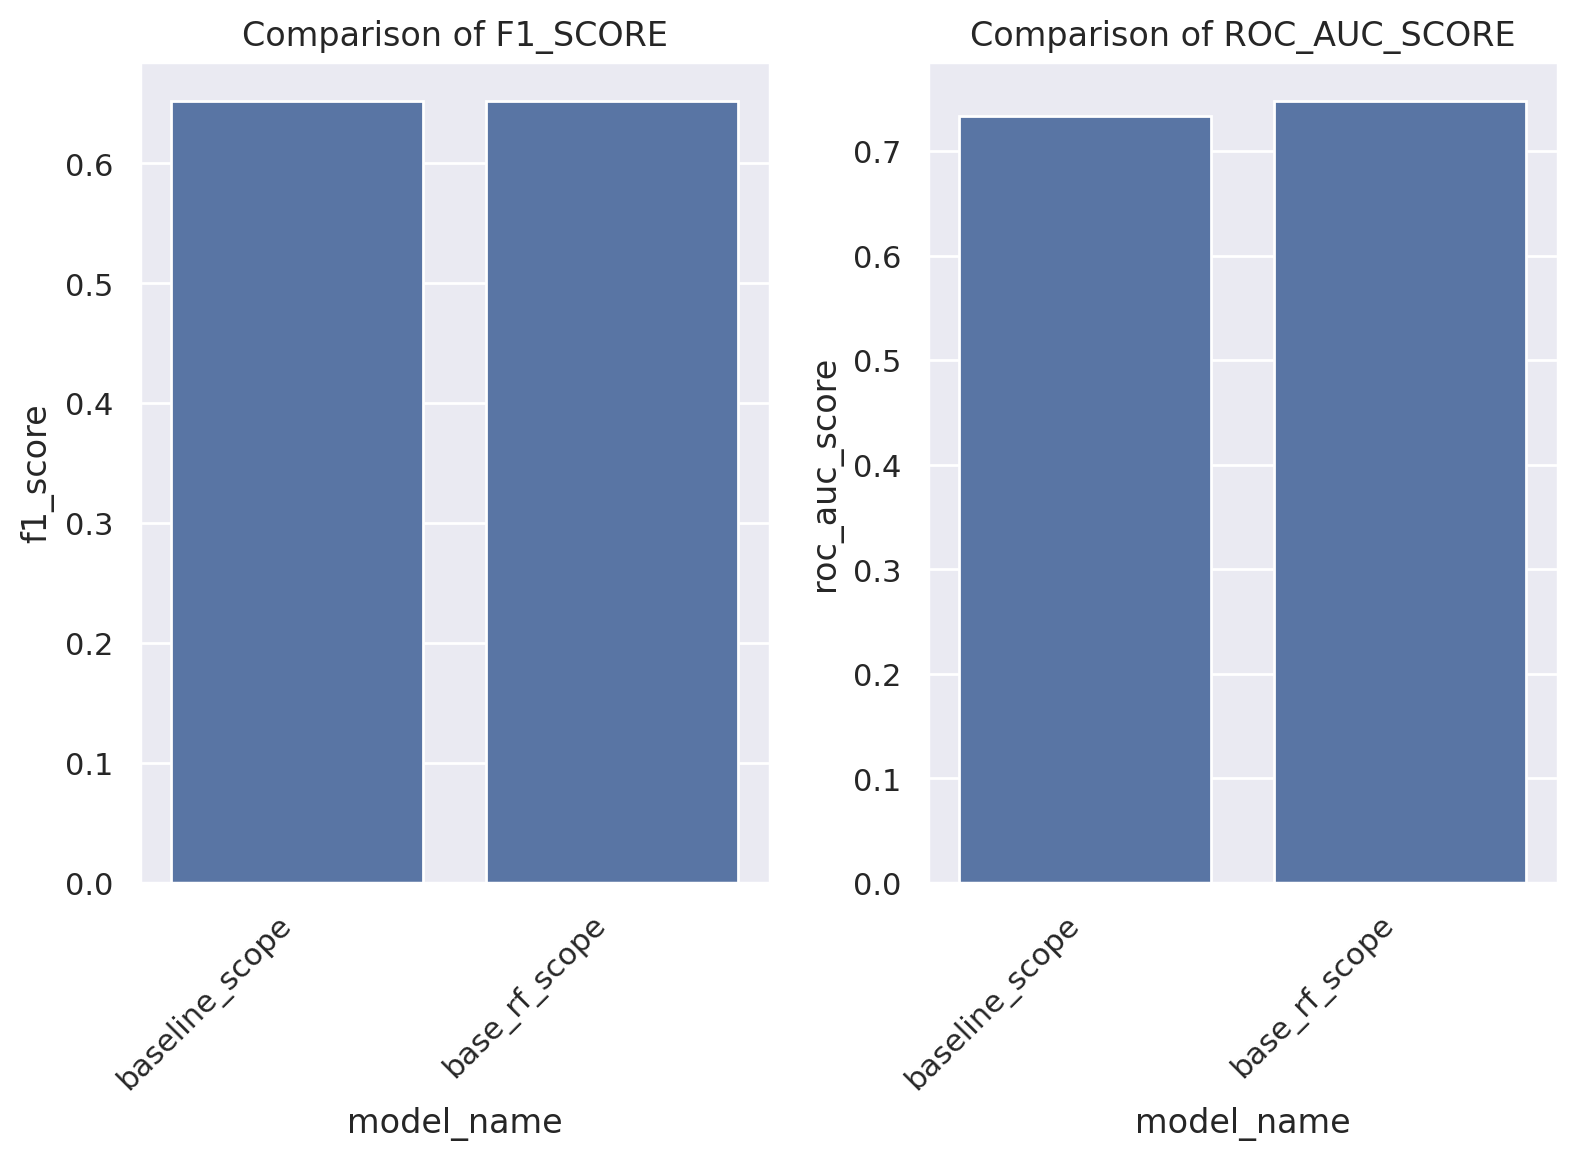

In [15]:
models_comparison(save_figure=False)

#### Вывод
- модель случайного леса с гиперпараметрами по умолчанию
  <br>показала результат незначительно превосходящий базовую модель.

## Генерация дополнительных признаков

In [11]:
for feature in ['rate', 'rv_perc', 'ctr_sort']:
    mean_by_city = df.groupby('city_id')[feature].transform('mean')
    mean_by_region = df.groupby('region_id')[feature].transform('mean')
    df[f'mean_{feature}_by_city'] = mean_by_city
    df[f'mean_{feature}_by_region'] = mean_by_region
print(f"Добавлены средние значения признаков 'rate', 'rv_perc', 'ctr_sort' по городам и регионам")
df.info()

Добавлены средние значения признаков 'rate', 'rv_perc', 'ctr_sort' по городам и регионам
<class 'pandas.core.frame.DataFrame'>
Index: 990388 entries, 0 to 990387
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   region_id                990388 non-null  int64  
 1   city_id                  990388 non-null  int64  
 2   tags_cont                990388 non-null  float64
 3   tags_bhv                 990388 non-null  float64
 4   rubrica                  990388 non-null  float64
 5   rate                     990388 non-null  float64
 6   ctr_sort                 990388 non-null  float64
 7   rv_perc                  990388 non-null  float64
 8   slider                   990388 non-null  int64  
 9   position_type            990388 non-null  int64  
 10  target                   990388 non-null  int64  
 11  mean_rate_by_city        990388 non-null  float64
 12  mean_rate_by_region      99038

In [12]:
X_train, X_test, y_train, y_test = data_preprocessing(test_size=TEST_SIZE,
                                                      dataset=df,
                                                      features=df.drop(['position_type', 'target'], axis=1).columns.tolist(),
                                                      target='target',
                                                      transformations=None)

размерности выборок: ((891349, 15), (99039, 15), (891349,), (99039,))


## Обучение моделей

### Случайный лес

результаты кросс-вадидации: {'fit_time': 107.249, 'score_time': 1.571, 'test_roc_auc': 0.75, 'test_f1_micro': 0.685, 'test_f1': 0.668, 'test_f1_weighted': 0.685, 'test_f1_macro': 0.684}


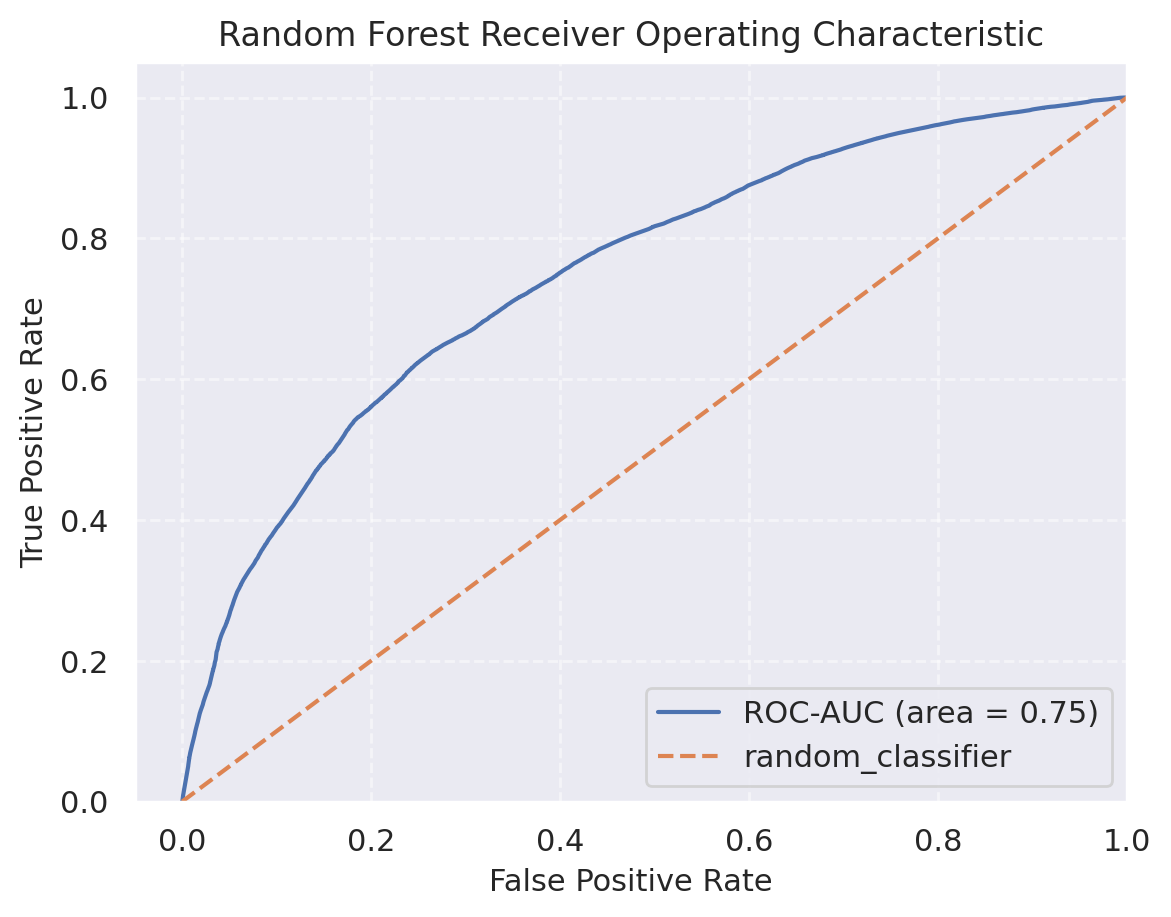

In [18]:
rf_params = {'n_estimators': 100,
             'criterion': 'gini',
             'max_depth': 3,
             'class_weight': 'balanced',
             'random_state': RANDOM_STATE,
             'n_jobs': -1}
f1_rf, roc_auc_rf, base_rf = model_fitting(model_name='Random Forest',
                                           features_train=X_train,
                                           target_train=y_train,
                                           n_splits=round(X_train.shape[0]/X_test.shape[0]),
                                           params=rf_params)

In [22]:
signature = mlflow.models.infer_signature(X_train, y_train)
input_example = X_train[:10]
metadata = {
    "author": "denis_zeit",
    "training_date": "2024-06-14",
    "data_used": 'clean_common_df_with_ext_features',
    "library_versions": {"mlflow": "2.11.3",
                         "scikit-learn":"1.5.0"}
}
metrics_rf = {'f1_score': f1_rf, 'roc_auc_score': roc_auc_rf}

model_logging(signature=signature,
              input_example=input_example,
              metadata=metadata,
              metrics=metrics_rf,
              model=base_rf,
              params=rf_params,
              run_name='base_rf_with_ext_features',
              reg_model_name='base_rf_scope')

/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'base_rf_scope' already exists. Creating a new version of this model...
2024/06/14 16:42:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version t

Models and their metrics:


,experiment_name,run_name,model_name,model_version,f1_score,roc_auc_score
0,click_pred,baseline_0_registry,baseline_scope,1,0.652,0.734
1,click_pred,base_rf_registry,base_rf_scope,1,0.652,0.748
2,click_pred,base_rf_with_ext_features,base_rf_scope,2,0.668,0.750


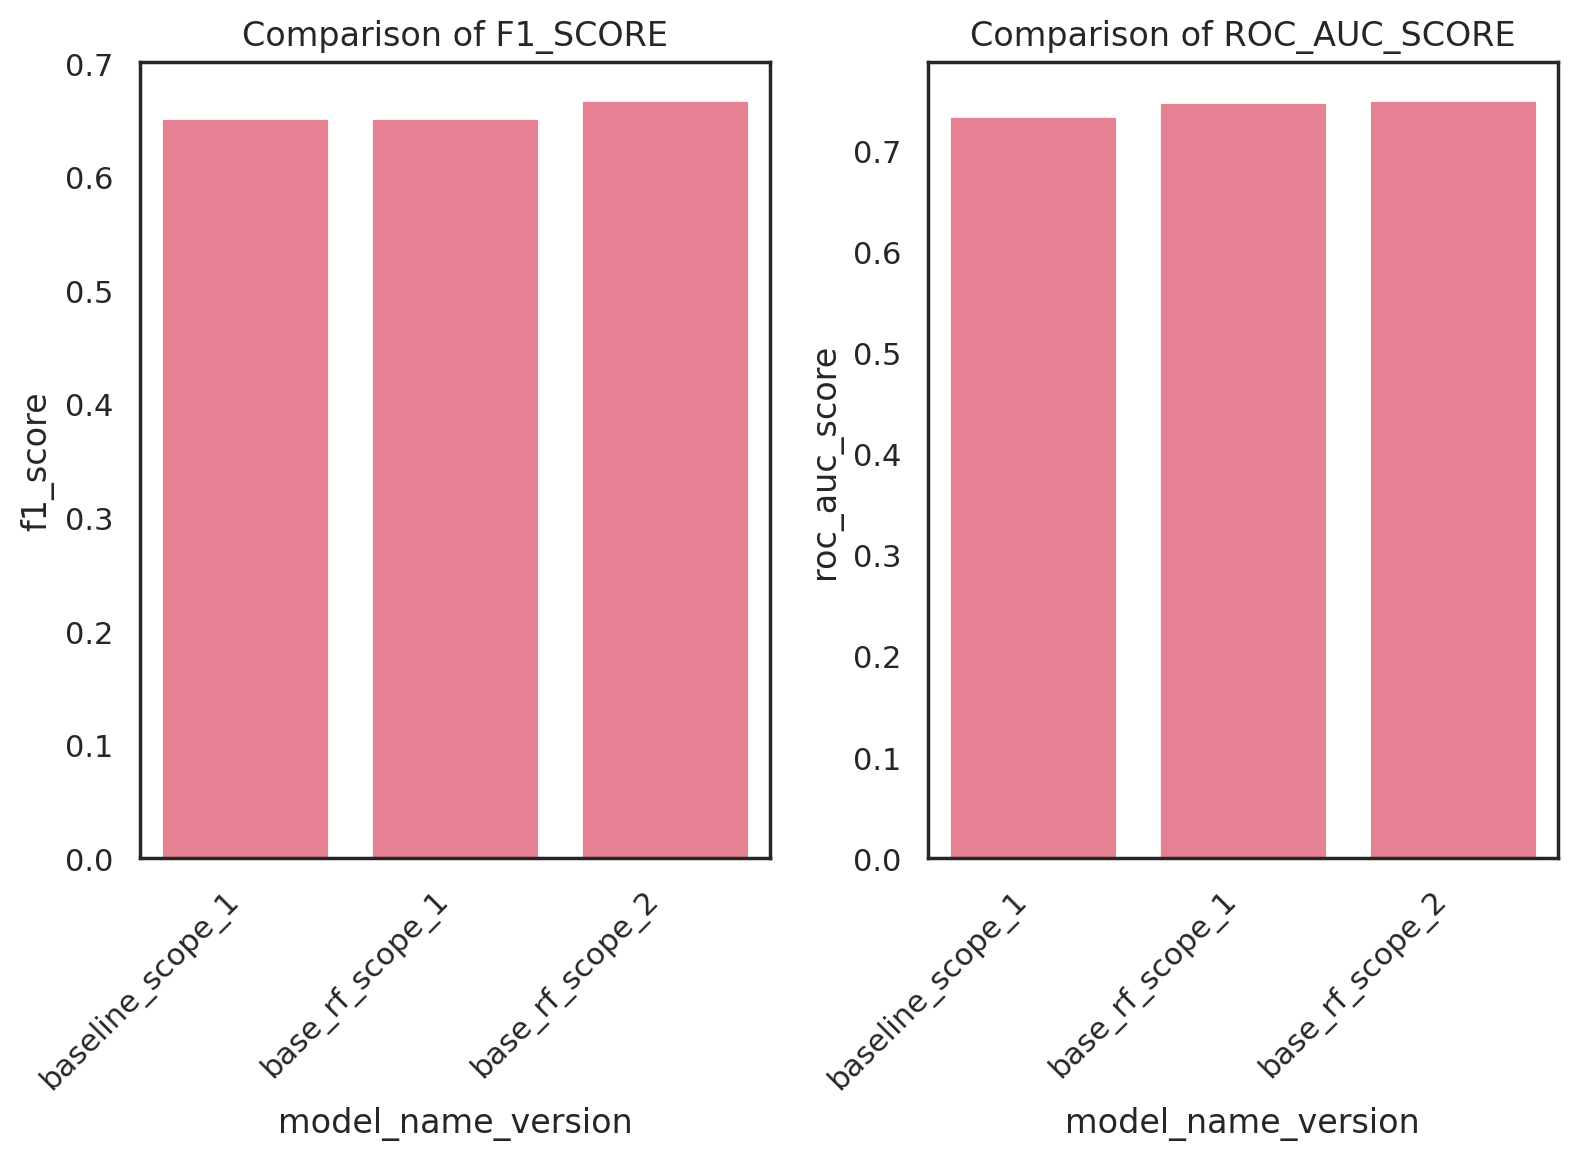

In [24]:
models_comparison(save_figure=False)

#### Вывод
- использование дополнительных признаков значительного прироста метрик не дало

### Градиентный бустинг

/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Number of positive: 430402, number of negative: 460947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2666
[LightGBM] [Info] Number of data points in the train set: 891349, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482866 -> initscore=-0.068563
[LightGBM] [Info] Start training from score -0.068563


/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_war

результаты кросс-вадидации: {'fit_time': 43.157, 'score_time': 2.944, 'test_roc_auc': 0.803, 'test_f1_micro': 0.726, 'test_f1': 0.71, 'test_f1_weighted': 0.726, 'test_f1_macro': 0.725}
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


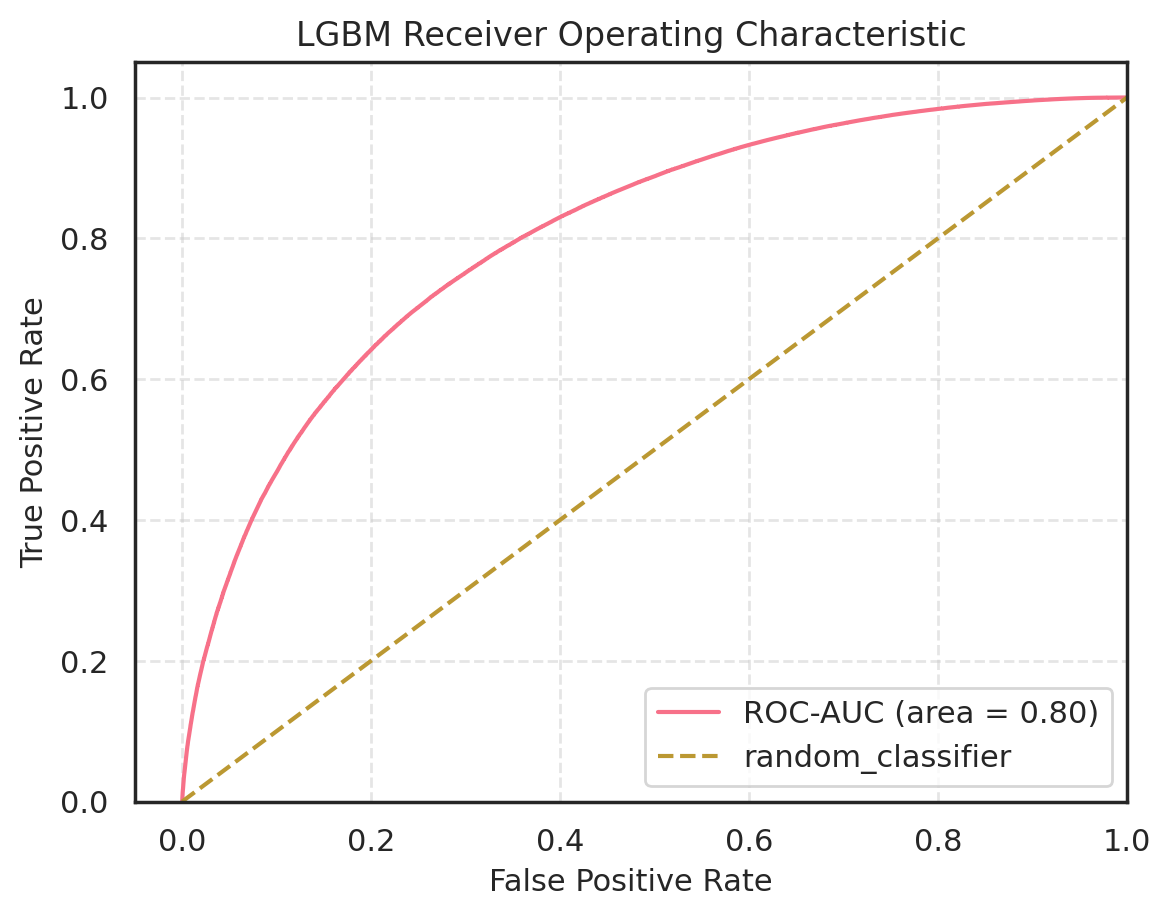

In [17]:
gb_params = {'num_iterations': 100,
             'learning_rate': 0.1,
             'num_leaves': 31,
             'boosting': 'gbdt',
             'seed': RANDOM_STATE,
             'num_threads': 0}
f1_gb, roc_auc_gb, base_gb = model_fitting(model_name='LGBM',
                                           features_train=X_train,
                                           target_train=y_train,
                                           n_splits=round(X_train.shape[0]/X_test.shape[0]),
                                           params=gb_params)

In [22]:
signature = mlflow.models.infer_signature(X_train, y_train)
input_example = X_train[:10]
metadata = {
    "author": "denis_zeit",
    "training_date": "2024-06-14",
    "data_used": 'clean_common_df_with_ext_features',
    "library_versions": {"mlflow": "2.11.3",
                         "scikit-learn":"1.5.0",
                         "lightgbm": "4.4.0"}
}
metrics_gb = {'f1_score': f1_gb, 'roc_auc_score': roc_auc_gb}

model_logging(signature=signature,
              input_example=input_example,
              metadata=metadata,
              metrics=metrics_gb,
              model=base_gb,
              params=gb_params,
              run_name='base_gb_with_ext_features',
              reg_model_name='base_gb_scope')

/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'base_gb_scope'.
2024/06/15 17:26:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: base_gb_sco

Models and their metrics:


,experiment_name,run_name,model_name,model_version,f1_score,roc_auc_score
0,click_pred,baseline_0_registry,baseline_scope,1,0.652,0.734
1,click_pred,base_rf_registry,base_rf_scope,1,0.652,0.748
2,click_pred,base_rf_with_ext_features,base_rf_scope,2,0.668,0.750
3,click_pred,base_gb_with_ext_features,base_gb_scope,1,0.710,0.803


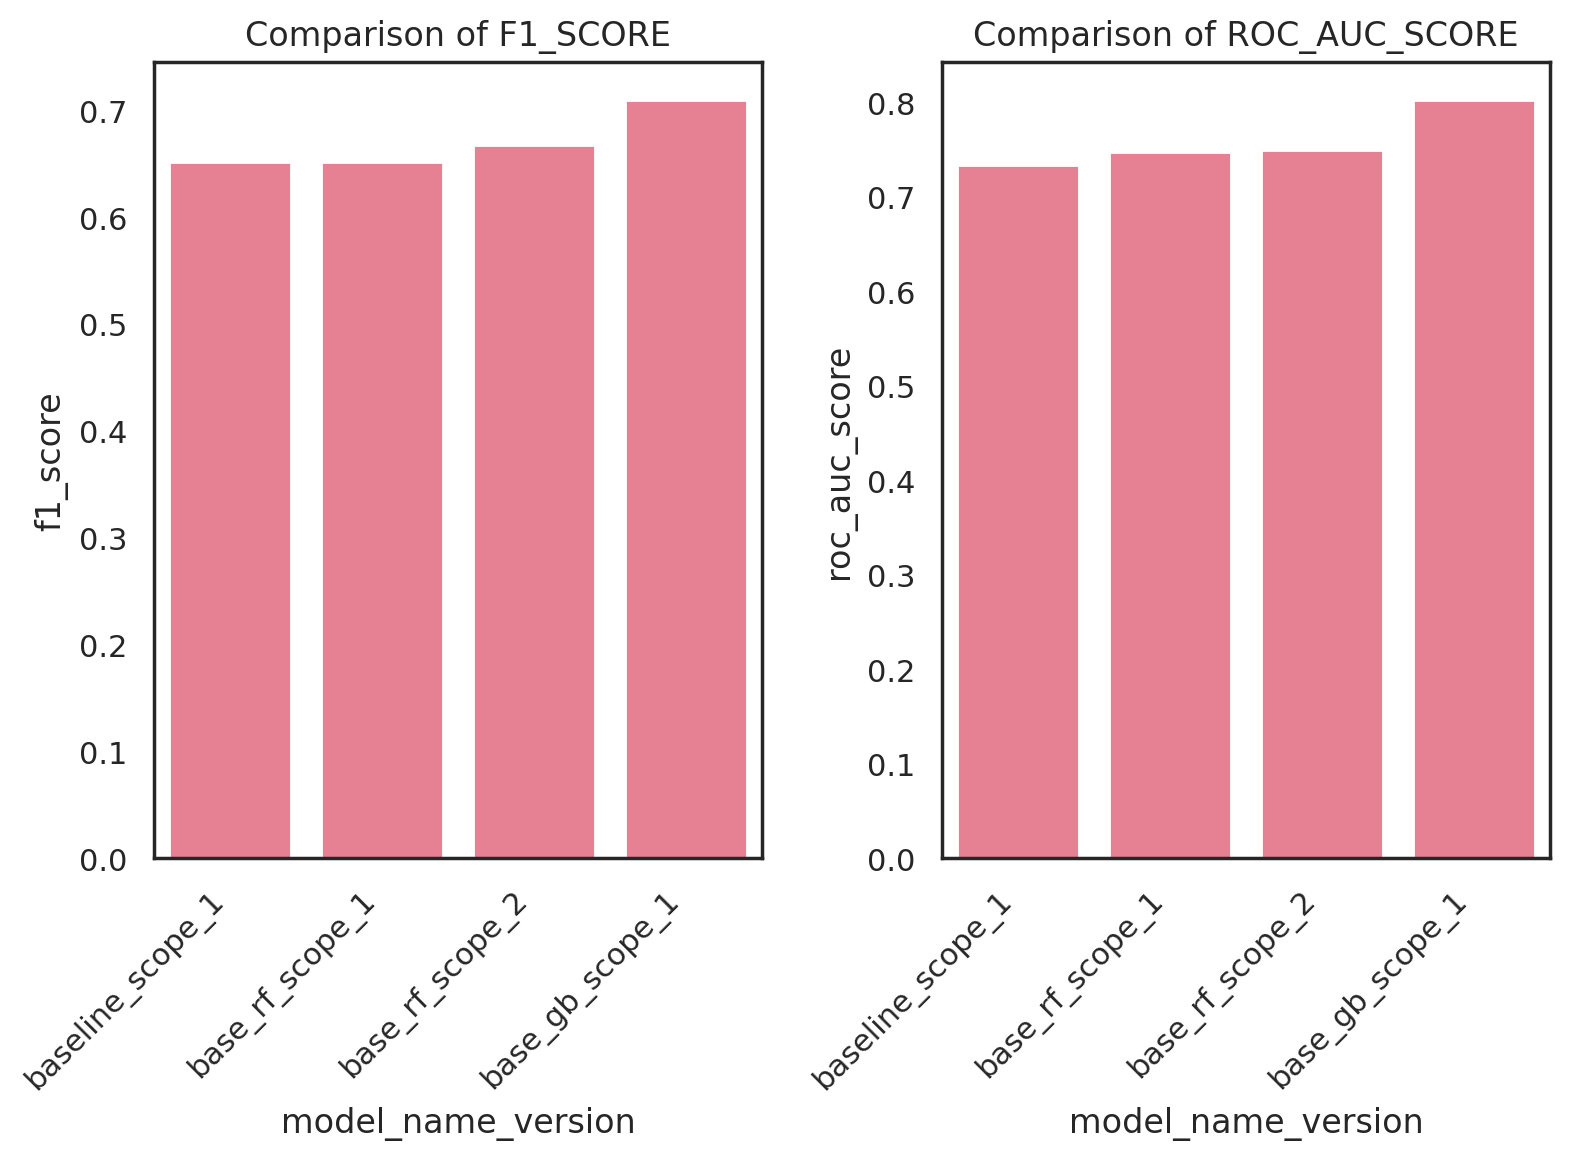

In [23]:
models_comparison(save_figure=False)

### Вывод
- использование модели градиентного бустинга позволило поднять метрики,
  <br>но их уровень всё ещё не достаточно хорош.

### Градиентный бустинг с подбором гиперпараметров

/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_war

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Number of positive: 382580, number of negative: 409730
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.171635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2668
[LightGBM] [Info] Number of data points in the train set: 792310, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482867 -> initscore=-0.068561
[LightGBM] [Info] Start training from score -0.068561
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightG

/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Number of positive: 382579, number of negative: 409731
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.388540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2676
[LightGBM] [Info] Number of data points in the train set: 792310, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482865 -> initscore=-0.068566
[LightGBM] [Info] Start training from score -0.068566
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be i

/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Number of positive: 382579, number of negative: 409731
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.209471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2670
[LightGBM] [Info] Number of data points in the train set: 792310, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482865 -> initscore=-0.068566
[LightGBM] [Info] Start training from score -0.068566
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightG

/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Number of positive: 382580, number of negative: 409730
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.179990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2668
[LightGBM] [Info] Number of data points in the train set: 792310, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482867 -> initscore=-0.068561
[LightGBM] [Info] Start training from score -0.068561
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightG

/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Number of positive: 382579, number of negative: 409731
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.472240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2671
[LightGBM] [Info] Number of data points in the train set: 792310, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482865 -> initscore=-0.068566
[LightGBM] [Info] Start training from score -0.068566
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be i

/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_war

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Number of positive: 382579, number of negative: 409731
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2680
[LightGBM] [Info] Number of data points in the train set: 792310, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482865 -> initscore=-0.068566
[LightGBM] [Info] Start training from score -0.068566
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightG

/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Number of positive: 430402, number of negative: 460947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2666
[LightGBM] [Info] Number of data points in the train set: 891349, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482866 -> initscore=-0.068563
[LightGBM] [Info] Start training from score -0.068563
Лучшие гиперпараметры: {'seed': 42, 'num_threads': 0, 'num_leaves': 35, 'num_iterations': 1000, 'learning_rate': 0.1, 'boosting': 'gbdt'}
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Curren

/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Number of positive: 430402, number of negative: 460947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2666
[LightGBM] [Info] Number of data points in the train set: 891349, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482866 -> initscore=-0.068563
[LightGBM] [Info] Start training from score -0.068563


/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_war

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Number of positive: 382580, number of negative: 409731
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.309096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2679
[LightGBM] [Info] Number of data points in the train set: 792311, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482866 -> initscore=-0.068563
[LightGBM] [Info] Start training from score -0.068563
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be i

/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


результаты кросс-вадидации: {'fit_time': 188.184, 'score_time': 75.93, 'test_roc_auc': 0.823, 'test_f1_micro': 0.744, 'test_f1': 0.731, 'test_f1_weighted': 0.744, 'test_f1_macro': 0.743}
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


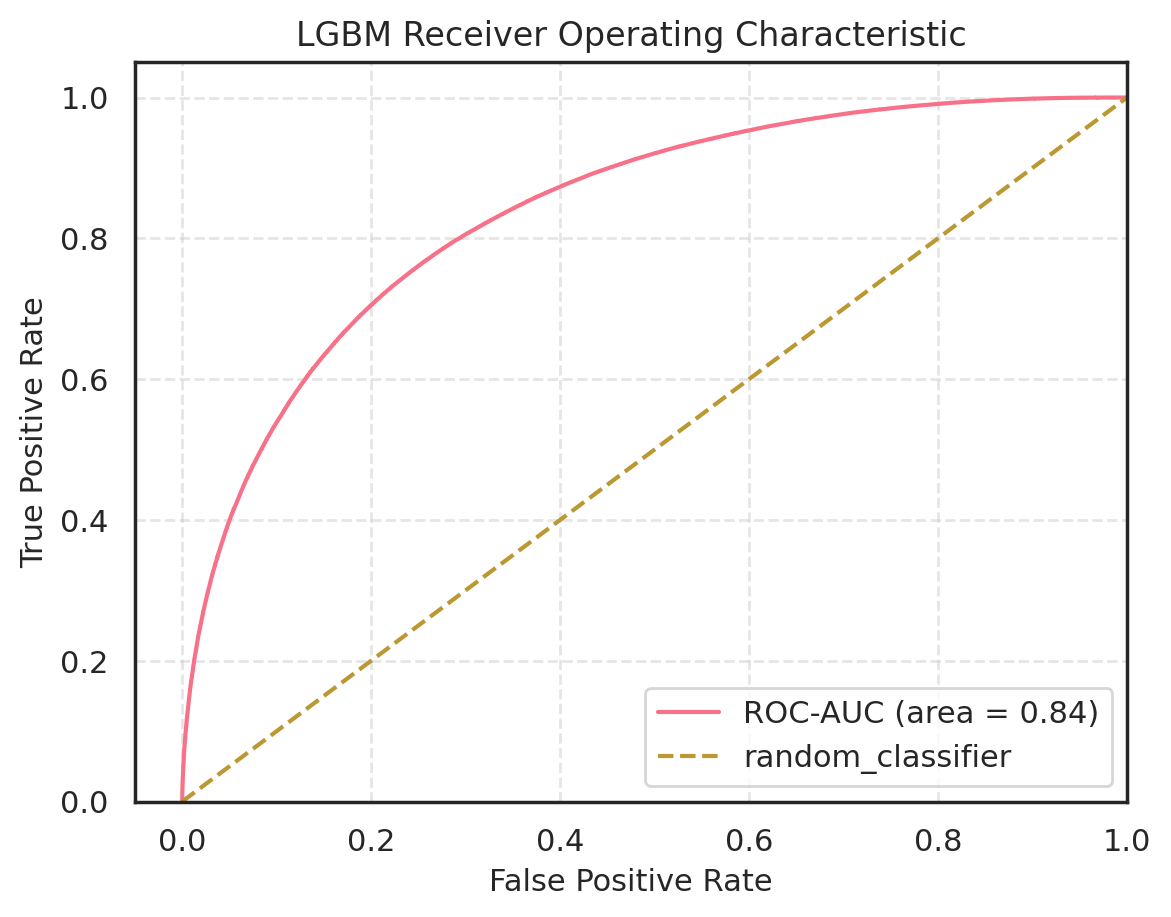

In [28]:
gb_params = {'num_iterations': np.arange(100, 1001, 100),
             'learning_rate': [0.01, 0.05, 0.1],
             'num_leaves': np.arange(31, 62),
             'boosting': ['gbdt'],
             'seed': [RANDOM_STATE],
             'num_threads': [0]}
f1_gb, roc_auc_gb, base_gb = model_fitting(model_name='LGBM',
                                           features_train=X_train,
                                           target_train=y_train,
                                           n_splits=round(X_train.shape[0]/X_test.shape[0]),
                                           params=gb_params,
                                           tune_hyperparams=True)

In [34]:
signature = mlflow.models.infer_signature(X_train, y_train)
input_example = X_train[:10]
metadata = {
    "author": "denis_zeit",
    "training_date": "2024-06-15",
    "data_used": 'clean_common_df_with_ext_features',
    "library_versions": {"mlflow": "2.11.3",
                         "scikit-learn":"1.5.0",
                         "lightgbm": "4.4.0"}
}
metrics_gb = {'f1_score': f1_gb, 'roc_auc_score': roc_auc_gb}

model_logging(signature=signature,
              input_example=input_example,
              metadata=metadata,
              metrics=metrics_gb,
              model=base_gb,
              params=base_gb.get_params(),
              run_name='rs_gb_with_ext_features',
              reg_model_name='rs_gb_scope')

/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also

Models and their metrics:


,experiment_name,run_name,model_name,model_version,f1_score,roc_auc_score
0,click_pred,baseline_0_registry,baseline_scope,1,0.652,0.734
1,click_pred,base_rf_registry,base_rf_scope,1,0.652,0.748
2,click_pred,base_rf_with_ext_features,base_rf_scope,2,0.668,0.750
3,click_pred,base_gb_with_ext_features,base_gb_scope,1,0.710,0.803
4,click_pred,rs_gb_with_ext_features,rs_gb_scope,1,0.731,0.823


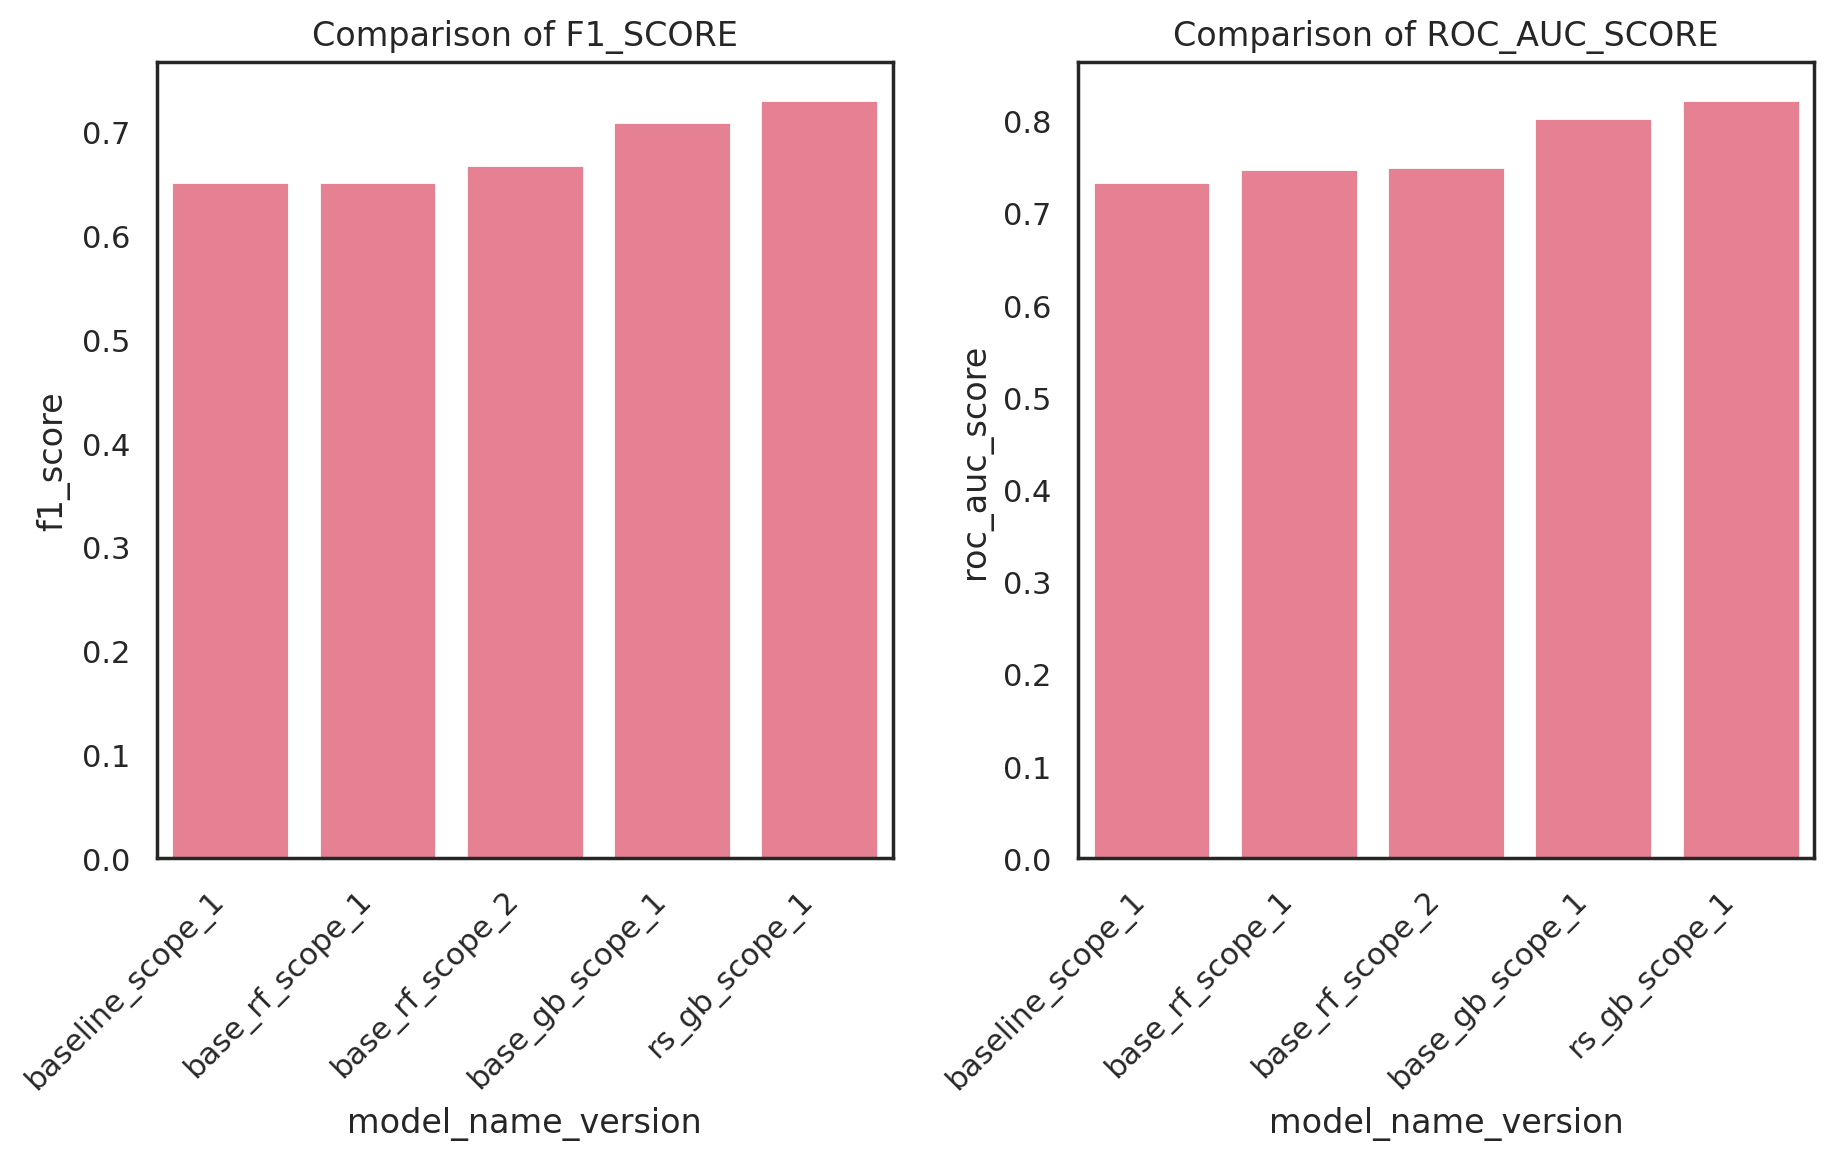

In [35]:
models_comparison(save_figure=False)

#### Вывод
- на модели градиентного бустинга с гиперпараметрами,
  <br>подобранными при помощи Randomized Search получена метрика `ROC AUC = 0.823`;
- пока это лучший результат, но всё ещё не идеальный.

## Проверка лучшей модели на отложенной выборке

In [5]:
model = joblib.load('services/app/model.pkl')

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
ROC-AUC на тестовой выборке: 0.82
F1 на тестовой выборке: 0.73


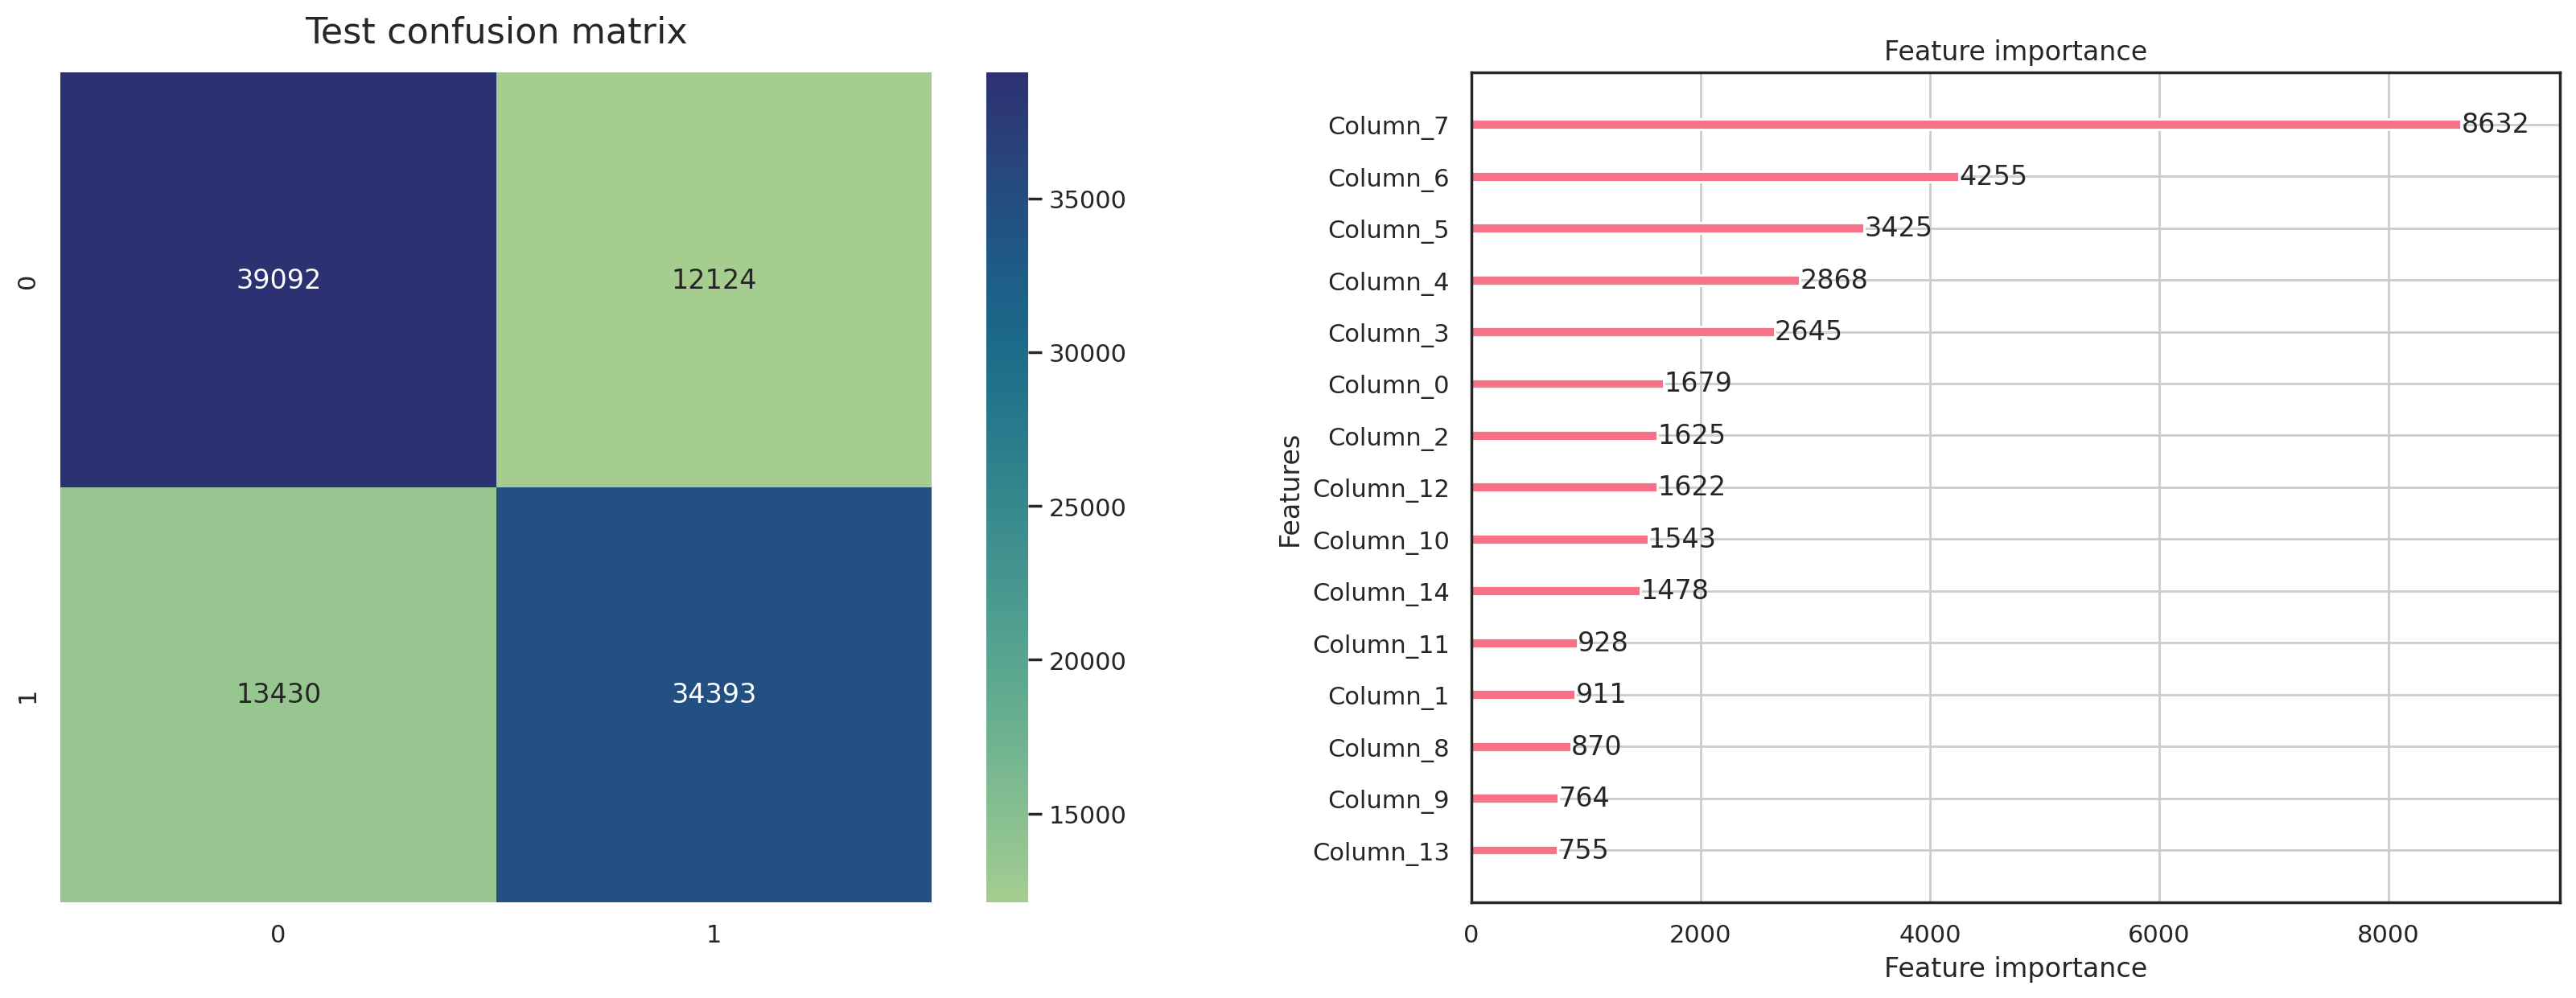

In [19]:
test_best_model(model_name='LGBM',
                model=model,
                features_train=X_train.columns.tolist(),
                features_test=X_test,
                target_test=y_test,
                save_figure=True)

In [15]:
print(f"Наиболее важными признаками модель определила: {X_train.columns.tolist()[7:2:-1]}")

Наиболее важными признаками модель определила: ['rv_perc', 'ctr_sort', 'rate', 'rubrica', 'tags_bhv']


### Выводы
- На тестовой выборке модель показала неплохой результат `ROC AUC = 0.82`;
- Модель верно предсказала 39092 отрицательных примеров и 34393 положительных примера;
- Модель ошибочно предсказала 12124 отрицательных примеров как положительные и 13430 положительных примеров как отрицательные;
- Наиболее важными для модели признаками определены:
  - процент видимости объявления;
  - значение ctr объявления;
  - ставка в рублях объявления;
  - тематика объявления;
  - значение таргетинга по поведению.